In [84]:
# !pip install nb_black
# %load_ext lab_black
# Load the TensorBoard notebook extension.
%reload_ext tensorboard

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import tensorflow as tf
import tensorboard
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert (
    version.parse(tf.__version__).release[0] >= 2
), "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.5.0


In [67]:
import tensorboard

tensorboard.__version__

'2.5.0'

In [68]:
# Clear any logs from previous runs
# rm -rf ./logs/

In [69]:
data_dir = "data/"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

599


In [70]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    label_mode="int",
    image_size=(img_height, img_width),
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    label_mode="int",
    image_size=(img_height, img_width),
)

Found 647 files belonging to 5 classes.
Using 518 files for training.
Found 647 files belonging to 5 classes.
Using 129 files for validation.


In [71]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['badminton', 'basketball', 'cricket', 'hockey', 'volleyball']


> Sample Plot

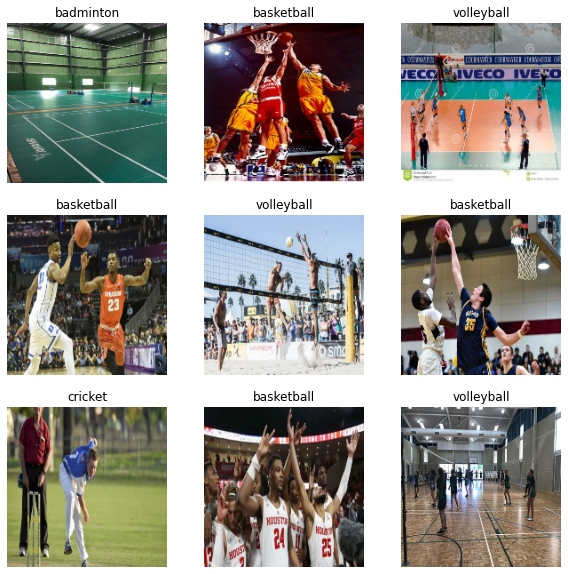

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

> Checking number of images in each batch

In [73]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


> Prefetching the data so not to bottleneck the I/O

In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating The Model

In [75]:
# num_classes = 5

model = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 3)
        ),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes),
    ]
)

### Compiling the Model

In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Loading tensorboard for visualization.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

### Training the Model

In [77]:
epochs = 20
history = model.fit(
    train_ds, validation_data=val_ds, epochs=epochs, callbacks=[tensorboard_callback]
)

Epoch 1/20
17/17 [==============================] - 3s 122ms/step - loss: 2.0631 - accuracy: 0.2819 - val_loss: 1.5258 - val_accuracy: 0.2791
Epoch 2/20
17/17 [==============================] - 0s 28ms/step - loss: 1.3391 - accuracy: 0.4054 - val_loss: 1.1711 - val_accuracy: 0.6047
Epoch 3/20
17/17 [==============================] - 0s 29ms/step - loss: 1.0362 - accuracy: 0.5888 - val_loss: 0.9346 - val_accuracy: 0.6667
Epoch 4/20
17/17 [==============================] - 0s 30ms/step - loss: 0.8224 - accuracy: 0.7066 - val_loss: 0.7703 - val_accuracy: 0.7287
Epoch 5/20
17/17 [==============================] - 0s 29ms/step - loss: 0.6987 - accuracy: 0.7606 - val_loss: 0.7479 - val_accuracy: 0.7442
Epoch 6/20
17/17 [==============================] - 0s 28ms/step - loss: 0.5985 - accuracy: 0.7896 - val_loss: 0.7561 - val_accuracy: 0.6822
Epoch 7/20
17/17 [==============================] - 1s 30ms/step - loss: 0.5894 - accuracy: 0.7780 - val_loss: 0.7292 - val_accuracy: 0.7287
Epoch 8/20
1

In [79]:
# !kill port 9484
# %tensorboard --logdir logs

In [40]:
# !tensorboard dev upload    --logdir logs    --name "Sample op-level graph"    --one_shot

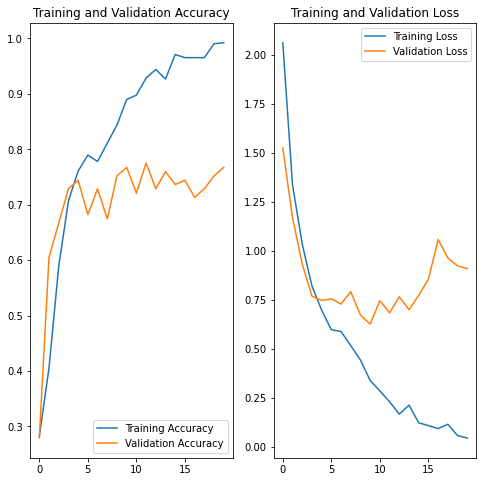

In [80]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.savefig("model_traning.png")
plt.show()

In [81]:
!mkdir  saved_model
model.save("saved_model/my_model")

A subdirectory or file saved_model already exists.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


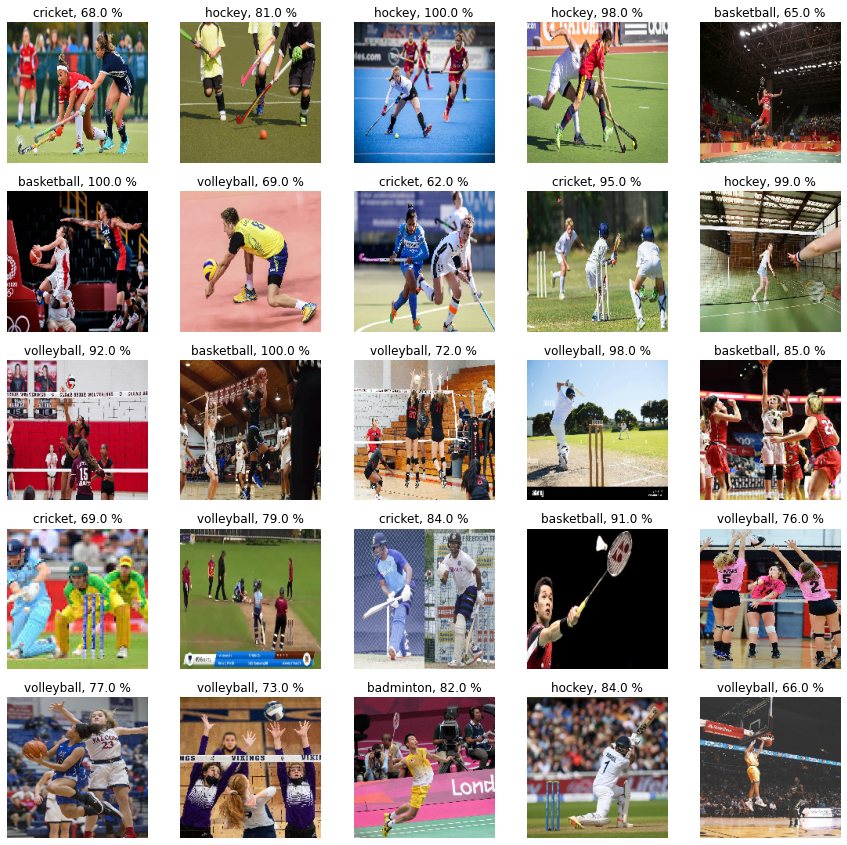

In [82]:
plt.figure(figsize=(15, 15))

for i, image_path in enumerate(os.listdir("testset")):
    if ".jpg" in image_path:
        img = tf.keras.preprocessing.image.load_img(
            os.path.join("testset", image_path), target_size=(img_height, img_width)
        )
        input_arr = tf.keras.preprocessing.image.img_to_array(img)

        input_arr = np.array([input_arr])  # Convert single image to a batch.
        predictions = model.predict(input_arr)

        # predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        pred_acc = 100 * np.max(score)
        pred_class = class_names[np.argmax(score)]

        # Plotting the predicted images
        ax = plt.subplot(5, 5, i)
        plt.imshow(input_arr[0].astype("uint8"))
        plt.title(f"{pred_class}, {np.round(pred_acc)} %")
        plt.axis("off")

        # print(
        #     "This image most likely belongs to {} with a {:.2f} percent confidence,{}.".format(
        #         pred_class, pred_acc, image_path
        #     )
        # )
plt.savefig("model_prediction.png")